In [ ]:
#Import Required Libraries
!pip install matplotlib pandas scikit-learn seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
#Combine Date & Time to Create a Datetime Column
df = pd.read_csv("individual household electric power consumption dataset.Book1.csv")
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.head()


<ipython-input-11-9a3f6216dc55>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Global_active_power,Voltage,Global_intensity
Datetime,,,
2006-12-16 17:24:00,4.216,234.84,18.4
2006-12-16 17:25:00,5.360,233.63,23.0
2006-12-16 17:26:00,5.374,233.29,23.0
2006-12-16 17:27:00,5.388,233.74,23.0
2006-12-16 17:28:00,3.666,235.68,15.8


In [ ]:
#Handle Missing / Corrupt Data
df.replace("?", np.nan, inplace=True)

# Convert only the data columns to float, leaving the index as DatetimeIndex
# Identify columns that are not the index before converting
data_cols = df.columns
df[data_cols] = df[data_cols].astype(float)

df.dropna(inplace=True)  # Drop rows with missing values

#Add time-based features
# Now df.index is still a DatetimeIndex, so you can access time-based attributes
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday

In [ ]:
# Derived Power Feature
df['Derived_Power'] = df['Voltage'] * df['Global_intensity'] / 1000  # kW

# Lag Features: 1 and 2 previous steps
df['Lag_1'] = df['Global_active_power'].shift(1)
df['Lag_2'] = df['Global_active_power'].shift(2)

# Rolling Mean and Std over 3 samples
df['Rolling_mean_3'] = df['Global_active_power'].rolling(window=3).mean()
df['Rolling_std_3'] = df['Global_active_power'].rolling(window=3).std()

# Drop resulting NaNs from lag/rolling operations
df.dropna(inplace=True)


In [ ]:
#Updated Feature Set
X = df.drop("Global_active_power", axis=1)
y = df["Global_active_power"]
# Save datetime index
datetime_index = X.index
print(X.shape)
X.head()

(1044504, 11)


,Voltage,Global_intensity,Hour,Day,Month,Weekday,Derived_Power,Lag_1,Lag_2,Rolling_mean_3,Rolling_std_3
Datetime,,,,,,,,,,,
2006-12-16 17:26:00,233.29,23.0,17,16,12,5,5.365670,5.360,4.216,4.983333,0.664567
2006-12-16 17:27:00,233.74,23.0,17,16,12,5,5.376020,5.374,5.360,5.374000,0.014000
2006-12-16 17:28:00,235.68,15.8,17,16,12,5,3.723744,5.388,5.374,4.809333,0.990180
2006-12-16 17:29:00,235.02,15.0,17,16,12,5,3.525300,3.666,5.388,4.191333,1.038912
2006-12-16 17:30:00,235.09,15.8,17,16,12,5,3.714422,3.520,3.666,3.629333,0.096381


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Determine the start index of the test set in the original dataframe
test_start_index = len(X_train)

# Restore datetime index to test set and y_test using slicing the original datetime_index
# The indices of X_test and y_test after the split are the integer positions relative to the split subset
# However, since shuffle=False, these correspond to the last part of the original index
X_test.index = datetime_index[test_start_index:]
y_test.index = datetime_index[test_start_index:]

In [ ]:
#Training
dt = DecisionTreeRegressor(random_state=42, max_depth=10)  # You can tune max_depth
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=10, random_state=42)

In [ ]:
#Evaluate Model
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    return mae, rmse, pred

dt_mae, dt_rmse, dt_pred = evaluate_model(dt, X_test, y_test)
print("Decision Tree - MAE:", dt_mae, " RMSE:", dt_rmse)


Decision Tree - MAE: 0.015965719534489654  RMSE: 0.028910956987240385


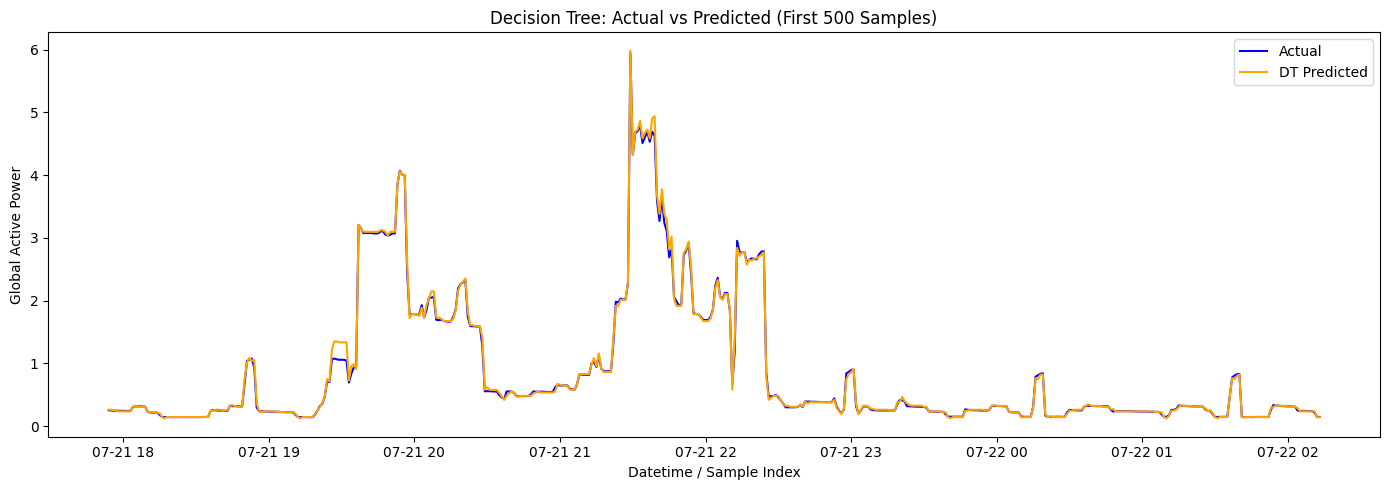

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_test[:500].index, y_test[:500], label='Actual', color='blue')
plt.plot(y_test[:500].index, dt_pred[:500], label='DT Predicted', color='orange')
plt.title('Decision Tree: Actual vs Predicted (First 500 Samples)')
plt.xlabel('Datetime / Sample Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()


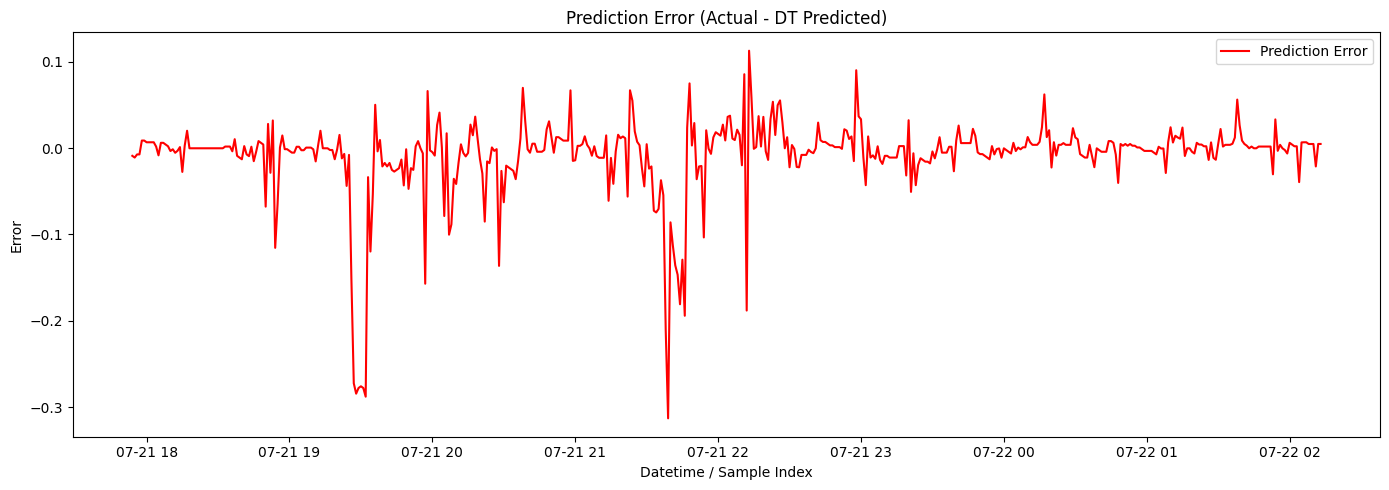

In [ ]:
#plot error
error = y_test[:500] - dt_pred[:500]
plt.figure(figsize=(14, 5))
plt.plot(y_test[:500].index, error, label='Prediction Error', color='red')
plt.title('Prediction Error (Actual - DT Predicted)')
plt.xlabel('Datetime / Sample Index')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

